# 0) Подготовка

In [ ]:
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [86]:
import sys
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download ru_core_news_sm
# !{sys.executable} -m pip install gensim
# !{sys.executable} -m pip install pyLDAvis
# !{sys.executable} -m pip install WordCloud

In [ ]:
# !pip uninstall gensim

In [ ]:
# !pip install gensim==4.3.0

In [ ]:
# !pip uninstall numpy
# !pip install numpy

In [ ]:
# !{sys.executable} -m pip show gensim

In [35]:
import json # обработка json файлов
import pandas as pd # работа с pandas DataFrame
import numpy as np # для работы с числами и последовательностями (финальный вывод)
import matplotlib.pyplot as plt # вывод графиков
import re # регулярные выражения для обработки статей
import string # обработка текста
import spacy # обработка текста + лемматизация слов (приведение к нормальной форме) + создание корпуса
import gensim # для объединения слов в n-граммы
import pyLDAvis.gensim_models # визуализация
import pickle # сохранение
from gensim.corpora import Dictionary # для создания словаря
from gensim.models import LdaModel, LsiModel, Nmf, HdpModel, CoherenceModel # модель + метрика оценивания
from wordcloud import WordCloud
from tqdm import tqdm
from IPython.display import Image # вывод картинки

import warnings # выключение отображение warning-ов
warnings.filterwarnings('ignore')

In [126]:
def print_coherence(models_arr, param_to_sort, model_name, plot_type="best"): # plot_type - вывод лучшей по параметру (param_to_sort) модели или усреднение
    # param_to_sort: для LDA это 0 - num_topics, 1 - alpha, 2 - beta
    # plot_type: "best", "avg"
    models_by_param = {}
    unique_param_vals = []
    
    for model in models_arr: # считаем уникальные значения выбранного параметра (param_to_sort)
        if model["params"][param_to_sort] not in unique_param_vals:
            unique_param_vals.append(model["params"][param_to_sort])
    unique_vals = len(unique_param_vals) # число уникальных значений
    
    for param in unique_param_vals: # создани словаря по  определённым значениям параметра (param_to_sort)
        models_by_param[param] = []
        for model in models_arr:
            if model["params"][param_to_sort] == param:
                models_by_param[param].append(model)      
    
    cohs = [] # массив когеренций
    if plot_type == "best": # если ищем лучшие, то "закрываем глаза" на другие параметры и ищем лучшиую модель при каждом значении параметра (param_to_sort)
        for param in unique_param_vals:
            best_coh = -9999999
            for model in models_by_param[param]:
                if model["coherence"] > best_coh:
                    best_coh = model["coherence"]
            cohs.append(best_coh)
    elif plot_type == "avg": # иначе - считаем, что другие параметры были значимыми и высчитываем среднее по всем параметрам при фиксированном параметре (param_to_sort)
        for param in unique_param_vals:
            other_params = 0
            avg_coh = 0
            for model in models_by_param[param]:
                other_params+=1
                avg_coh+=model["coherence"]
            cohs.append(avg_coh/other_params)
    else:
        raise Exception(r'param_to_sort should be "best" or "avg"')

        
    lsi_params={'num_topics': [i for i in range(5, 10)], 
            'onepass': [True, False],
            'power_iters': [0,1,2,3]}    
        
        
    if model_name == "LDA":
        param_to_sort = ["num_topics", "alpha", "beta"][param_to_sort]
    elif model_name == "LSI":
        param_to_sort = ["num_topics", "onepass", "power_iters"][param_to_sort]
    elif model_name == "NMF":
        param_to_sort = ["num_topics", "kappa"][param_to_sort]
    else:
        raise Exception(r'model_name should be "LDA", "LSI" or "NMF"')
    
    plt.figure(figsize=(10, 10))
    plt.title(plot_type)
    plt.plot(unique_param_vals, cohs)
    plt.xlabel(param_to_sort)
    plt.ylabel("Coherence score")
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# article_filename = "/content/drive/MyDrive/Универ/articles.json" # путь до файла с полным сохранением статей
article_filename = "articles.json" # путь до файла с полным сохранением статей

In [ ]:
# import gdown
# url = "https://drive.google.com/uc?id=1-8E0NiymGSV1cYnKFL3sZY8mkjCVXioe"
# output = "nlp_articles.pkl"

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1-8E0NiymGSV1cYnKFL3sZY8mkjCVXioe 



In [ ]:
# gdown.download(
#     f"https://drive.google.com/uc?export=download&confirm=pbef&id=1-8E0NiymGSV1cYnKFL3sZY8mkjCVXioe",
#     output
# )

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1-8E0NiymGSV1cYnKFL3sZY8mkjCVXioe
To: /content/nlp_articles.pkl
100%|██████████| 1.77G/1.77G [00:13<00:00, 129MB/s]


'nlp_articles.pkl'

# 1) Предобработка данных

In [13]:
articles = []
with open(article_filename, encoding="utf-8") as file:
    for line in file:
        articles.append(json.loads(line))
data = pd.DataFrame(articles)
data

,article_id,title,category,tags,text
0,https://www.nn.ru/text/entertainment/2023/01/1...,Кто такой цуцик и где раки зимуют? Попробуйте ...,entertainment,"Развлечения,Знания,История,Развлечения,Тест,Фр...","Если бы не было фразеологизмов, наша речь (а в..."
1,https://www.nn.ru/text/entertainment/2023/01/1...,Снова как мальчик: Филипп Киркоров резко помол...,entertainment,"Развлечения,Филипп Киркоров,Звезды,Шоу-бизнес","Редко кто может похвастаться тем, что после ка..."
2,https://www.nn.ru/text/entertainment/2023/01/1...,2023 — это колесница: каким будет год Черного ...,entertainment,"Развлечения,Гороскоп,Нумеролог,Прогноз нумерол...","Если присмотреться внимательнее, то можно обна..."
3,https://www.nn.ru/text/entertainment/2023/01/1...,Вам не решить: 10 советских задач в картинках ...,entertainment,"Развлечения,СССР,Интересный тест,Тест,Внимание...",Ставить опыты над возможностями человеческих п...
4,https://www.nn.ru/text/entertainment/2023/01/1...,Не только «Ёлки-9»: что больше всего приглянул...,entertainment,Развлечения,Wink представляет самые популярные фильмы и се...
...,...,...,...,...,...
6114,https://29.ru/text/economics/2018/07/12/65142951/,В Поморье за взятки на два миллиона будут суди...,economics,Экономика,Уголовное дело бывшего госинспектора отдела ав...
6115,https://29.ru/text/economics/2018/07/10/65132941/,В Поморье за год взлетели цены на хлеб и молочку,economics,Экономика,Не успело правительство региона отчитаться о с...
6116,https://29.ru/text/economics/2018/07/05/65115221/,Россельхозбанк запустил вклад «Надежное будущее»,economics,Экономика,АО «Россельхозбанк» предлагает клиентам новый ...
6117,https://29.ru/text/economics/2018/07/04/65112121/,Архангельское УФАС оштрафовало «Архэнергосбыт»...,economics,Экономика,Штраф на ПАО «Архэнергосбыт» наложен постановл...


In [14]:
nlp = spacy.load("ru_core_news_sm") # nlp (Natural Language Processing) - Объект Language с загруженным pipeline-ом (tok2vec, morphologizer, parser, senter, ner, attribute_ruler, lemmatizer)

In [15]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0', '\u200e'])

In [16]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', text) for text in data["text"]] # удаление ссылок
corpus = [text.lower() for text in corpus] # приведение к нижнему регистру
corpus = [re.sub(r'[\d\w-]{1,}\.(ru|com|ua)', ' ', text) for text in corpus] # удаление неполных ссылок
# в статьях нет \n или \t

regex_dig = re.compile('[%s]' % re.escape(string.digits))
corpus = [regex_dig.sub(' ', text) for text in corpus] # убираем цифры

regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
corpus = [regex_punct.sub(' ', text) for text in corpus] # убираем пунктуацию

regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
corpus = [regex_symb.sub(' ', text) for text in corpus] # убираем дополнительные символы

corpus = [re.sub(' +', ' ', text) for text in corpus] # оставляем максимум 1 пробел
corpus = [text.strip() for text in corpus] # удаляем лишние пробелы в начале и конце статей

In [ ]:
docs = []
for text in corpus:
    docs.append(nlp(text)) # передача данных в pipeline Natural Language Processing

сохранение, так как предыдущий блок очень долго выполнялся

In [ ]:
import pickle
with open(r'nlp_articles.pkl', 'wb') as f: # сохранение в бинарном формате (1.5 ГИГАБАЙТА?!)
    pickle.dump(docs, f)

In [17]:
# f = open(r'/content/drive/MyDrive/Универ/nlp_articles.pkl', 'rb')
# docs = pickle.load(f)
# print(docs[0][0].is_stop) # проверка работы

with open(r'nlp_articles.pkl', 'rb') as f:
    docs = pickle.load(f)
print(docs[0][0].is_stop) # проверка работы

True


In [18]:
data["text"][0]

'Если бы не было фразеологизмов, наша речь (а возможно, и вся жизнь) была бы куда скучнее. Но еще интереснее не просто пользоваться этими выражениями, но и знать, откуда они произошли и почему мы вообще так стали говорить. Узнать это мы и предлагаем вам прямо сейчас. И не бойтесь ошибиться — это тест не про исключительные знания, а про то, что нас окружает.   '

In [19]:
docs[0]

если бы не было фразеологизмов наша речь а возможно и вся жизнь была бы куда скучнее но еще интереснее не просто пользоваться этими выражениями но и знать откуда они произошли и почему мы вообще так стали говорить узнать это мы и предлагаем вам прямо сейчас и не бойтесь ошибиться это тест не про исключительные знания а про то что нас окружает

In [ ]:
# for ind, i in enumerate(docs[0]):
#     print(ind, "\t\t", i, "\t\t", i.pos_, "\t\t", i.is_stop)

In [20]:
texts, article, skl_texts = [], [], []
# additional_stop_words = 
# texts - массив лемматизированных статей (массив из массивов лемм для статей)
# article - массив лемм в одной статье (зануляется при окончании рассматриваемой статьи)
# skl_texts - массив текстов из лемм
for text in docs:
    for idx, w in enumerate(text): # проходимся по всем словам из выбранной статьи
        # если это не стоп-слово и не знак препинания (+ число, конец строки), добавляем его в нашу статью!
#         if not w.is_stop and not w.is_punct and not w.like_num and not w.text in additional_stop_words: # w.text - для взятия слова
        if not w.is_stop and not w.is_punct and not w.like_num and not w.pos_ == "VERB": # w.text - для взятия слова
            # добавляем лематизированную версию слова
            article.append(w.lemma_)
        # если это новая строка, это означает, что мы находимся в нашем следующем документе
        if idx == (len(text) - 1):
            skl_texts.append(' '.join(article))
            texts.append(article)
            article = []

In [21]:
print(texts[0])

['фразеологизм', 'речь', 'жизнь', 'скучный', 'интересный', 'выражение', 'прямо', 'тест', 'исключительный', 'знание']


In [22]:
print(skl_texts[0])

фразеологизм речь жизнь скучный интересный выражение прямо тест исключительный знание


### Объединение слов в n-граммы

In [23]:
bigram = gensim.models.Phrases(texts) # обучение модели нахождения n-грамм

In [24]:
print(texts[-1], "\n\n", bigram[texts[-1]])

['база', 'архангельский', 'филиал', 'россельхозбанк', 'адрес', 'архангельск', 'ул', 'карл', 'либкнехт', 'центр', 'оказание', 'услуга', 'бизнес', 'цоу', 'государственный', 'муниципальный', 'услуга', 'услуга', 'акционерный', 'общество', 'федеральный', 'корпорация', 'развитие', 'малый', 'средний', 'предпринимательство', 'юридический', 'лицо', 'индивидуальный', 'предприниматель', 'гражданин', 'предпринимательский', 'деятельность', 'представитель', 'малый', 'средний', 'предпринимательство', 'доступный', 'окно', 'приём', 'выдача', 'документ', 'цель', 'организация', 'предоставление', 'государственный', 'муниципальный', 'услуга', 'условие', 'соглашение', 'предприниматель', 'город', 'архангельск', 'документ', 'регистрация', 'юридический', 'лицо', 'консультация', 'налог', 'кредитный', 'продукт', 'банк', 'расчётный', 'счёт', 'депозит', 'комплексный', 'поддержка', 'малый', 'средний', 'предпринимательство', 'время', 'клиент', 'насколько', 'важный', 'максимум', 'услуга', 'место', 'появление', 'база'

In [25]:
texts_v2 = [bigram[line] for line in texts] # создаём массив лемм для статей с использованием биграммами (во многом он остался схож с обычным texts)

## Вывод самых часто используемых слов в статьях

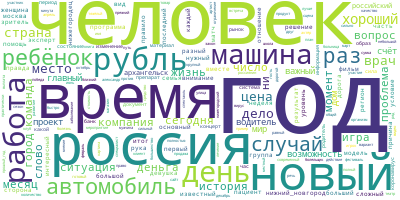

In [26]:
long_string = ','.join(j for sub in texts_v2 for j in sub) # объединяем все слова

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue') # создание WordCloud объекта

wordcloud.generate(long_string)
wordcloud.to_image()

In [27]:
dictionary = Dictionary(texts_v2) # создаём словарь (слова будут в нём не по порядку)

In [28]:
# print(dictionary[2]) # вывод слова по id
# print(dictionary.token2id["интересный"]) # вывод id, под которым слово записано в словаре

In [29]:
corpus = [dictionary.doc2bow(text) for text in texts_v2] # преобразовывание статей в формат bag-of-words (BoW)

In [30]:
corpus[0][0:10] # возвращает: (id слова в словаре, сколько раз оно встречается)

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

# 2) Выбор лучшей модели

### Для измерения качества предсказаний тем воспользуемся метрикой "UMass Coherence". Она измеряет частоту появления двух слов вместе в корпусе (считает попарное среднее значение когеренции N слов, описывающих тему). Легко интерпретируема и быстро высчитывается. Чем качественнее модель, тем UMass Coherence --> max (0).

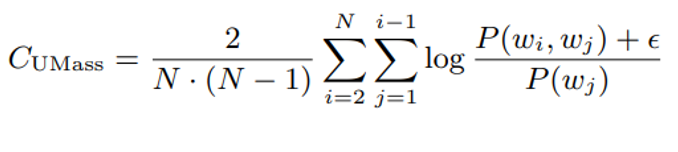

In [36]:
Image(filename='umass.png') 

## LSI (Latent Semantic Indexing):

In [ ]:
lsi_params={'num_topics': [i for i in range(5, 10)], 
            'onepass': [True, False],
            'power_iters': [0,1,2,3]}
lsi_models=[]

for num_topics in tqdm(lsi_params['num_topics']):
    for onepass in lsi_params['onepass']:
        for power_iters in lsi_params['power_iters']:
            # создание LSI модели с передачей корупа corpus, определяемое число тем = num_topics, id2word - ID to word mapping (используем созданный словарь)
            lsimodel = LsiModel(corpus=corpus, 
                              num_topics=num_topics, 
                              id2word=dictionary, 
                              onepass=onepass, 
                              power_iters=power_iters) # создание LSI модели с передачей корупа corpus, определяемое число тем = 10, id2word - ID to word mapping (используем созданный словарь)

            lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
            lsi_coherence = CoherenceModel(topics=lsitopics, texts=texts_v2, dictionary=dictionary, window_size=10, coherence="u_mass").get_coherence()

            lsi_models.append({'model': lsimodel, 'coherence': lsi_coherence, 'params': [num_topics, onepass, power_iters]})

In [ ]:
lsimodel.show_topics()  # Вывод тем для LSI модели

[(0,
  '0.634*"год" + 0.272*"человек" + 0.204*"рубль" + 0.170*"россия" + 0.155*"новый" + 0.147*"время" + 0.119*"ребёнок" + 0.106*"автомобиль" + 0.102*"цена" + 0.100*"машина"'),
 (1,
  '0.453*"человек" + -0.404*"рубль" + -0.248*"автомобиль" + -0.246*"год" + -0.216*"цена" + -0.201*"машина" + 0.169*"врач" + 0.147*"ребёнок" + 0.115*"время" + 0.104*"день"'),
 (2,
  '0.334*"матч" + 0.327*"игра" + 0.325*"команда" + -0.317*"человек" + 0.205*"болельщик" + 0.183*"нижний_новгород" + -0.144*"врач" + 0.131*"россия" + 0.120*"стадион" + -0.113*"ребёнок"'),
 (3,
  '-0.604*"год" + 0.252*"автомобиль" + 0.237*"человек" + 0.237*"рубль" + 0.233*"машина" + 0.225*"цена" + 0.185*"россия" + 0.110*"случай" + 0.094*"ситуация" + 0.083*"врач"'),
 (4,
  '-0.415*"автомобиль" + 0.398*"рубль" + -0.396*"машина" + -0.156*"водитель" + -0.155*"новый" + 0.132*"цена" + -0.113*"модель" + 0.111*"банк" + 0.105*"деньга" + 0.096*"валюта"'),
 (5,
  '-0.705*"ребёнок" + 0.342*"человек" + -0.217*"врач" + -0.138*"родитель" + -0.120*"

## NMF (Non-Negative Matrix Factorization):

In [ ]:
# nmfmodel = Nmf(corpus=corpus,
#                id2word=dictionary,
#                num_topics=10,
#                chunksize=chunksize,
#                kappa=0.1,
#                passes=passes,
#                eval_every=eval_every)

In [ ]:
nmf_params={'num_topics': [i for i in range(5, 10)], 
            'kappa': [0.1, 0.5, 1.0, 1.5]}
nmf_models=[]

for num_topics in tqdm(nmf_params['num_topics']):
    for kappa in nmf_params['kappa']:
        nmfmodel = Nmf(corpus=corpus, 
                      id2word=dictionary,
                      num_topics=num_topics) 

        nmftopics = [[word for word, prob in topic] for topicid, topic in nmfmodel.show_topics(formatted=False)]
        nmf_coherence = CoherenceModel(topics=nmftopics, texts=texts_v2, dictionary=dictionary, window_size=10, coherence="u_mass").get_coherence()

        nmf_models.append({'model': nmfmodel, 'coherence': nmf_coherence, 'params': [num_topics, kappa]})

In [ ]:
nmfmodel.show_topics() # Вывод тем для NMF модели

[(0,
  '0.034*"россия" + 0.013*"страна" + 0.008*"российский" + 0.007*"сегодня" + 0.006*"место" + 0.006*"ситуация" + 0.006*"время" + 0.005*"город" + 0.005*"нижний_новгород" + 0.005*"компания"'),
 (1,
  '0.021*"человек" + 0.019*"врач" + 0.009*"пациент" + 0.009*"случай" + 0.008*"препарат" + 0.007*"ребёнок" + 0.006*"заболевание" + 0.006*"день" + 0.006*"болезнь" + 0.005*"коронавирус"'),
 (2,
  '0.023*"ребёнок" + 0.007*"город" + 0.006*"новый" + 0.005*"дом" + 0.005*"спектакль" + 0.005*"история" + 0.005*"родитель" + 0.004*"театр" + 0.004*"программа" + 0.004*"интересный"'),
 (3,
  '0.029*"автомобиль" + 0.023*"машина" + 0.017*"новый" + 0.011*"модель" + 0.011*"россия" + 0.007*"цена" + 0.005*"автоваз" + 0.005*"год" + 0.005*"продажа" + 0.005*"марка"'),
 (4,
  '0.083*"человек" + 0.012*"работа" + 0.011*"деньга" + 0.007*"месяц" + 0.007*"дело" + 0.006*"жизнь" + 0.006*"время" + 0.004*"проблема" + 0.004*"нужный" + 0.004*"важный"'),
 (5,
  '0.094*"год" + 0.010*"деньга" + 0.010*"рубль" + 0.006*"сумма" + 0.

## LDA (Latent Dirichlet Allocation):

### Подбор параметров:

In [ ]:
lda_params = {'num_topics': [i for i in range(5, 10)], 
          'alpha': [*np.arange(0.01, 1, 0.3), 'auto', 'symmetric', 'asymmetric'], 
          'eta': [*np.arange(0.01, 1, 0.3), 'auto', 'symmetric']}

lda_models=[]

for num_topics in tqdm(lda_params['num_topics']):
    for alpha in lda_params['alpha']:
        for eta in lda_params['eta']:
            ldamodel = LdaModel(corpus=corpus, # передаваемый поток документов
                              num_topics=num_topics, # Количество запрошенных скрытых тем, которые необходимо извлечь из учебного корпуса.
                              id2word=dictionary, # Mapping id к словам (словарь)
                              chunksize=2000, # Количество документов, которые будут использоваться в каждом блоке обучения
                              alpha=alpha, # априорное убеждение в распространении тем по документам
                              eta=eta, # априорное убеждение в распределении слов по темам
                              passes=10, # Количество проходов по корпусу во время обучения
                              iterations=200, # Максимальное количество итераций по корпусу при выводе тематического распределения корпуса
                              eval_every=None) # Don't evaluate model perplexity, takes too much time.

            ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
            lda_coherence = CoherenceModel(topics=ldatopics, texts=texts_v2, dictionary=dictionary, window_size=10, coherence="u_mass").get_coherence()

            lda_models.append({'model': ldamodel, 'coherence': lda_coherence, 'params': [num_topics, alpha, eta]})       

In [34]:
# with open(r'/content/drive/MyDrive/Универ/lda_models1.pkl', 'wb') as f:
#     pickle.dump(lda_models, f)

with open(r'lda_models.pkl', 'wb') as f:
    pickle.dump(lda_models, f)

In [48]:
# with open(r'/content/drive/MyDrive/Универ/lda_models1.pkl', 'rb') as f:
#     lda_models = pickle.load(f)

with open(r'lda_models.pkl', 'rb') as f:
    lda_models = pickle.load(f)

### Вывод зависимости когеренции от числа тем

Лучшее (не обращаем внимание на tuning других параметров, взята лучшая комбинация при фиксированном параметре)

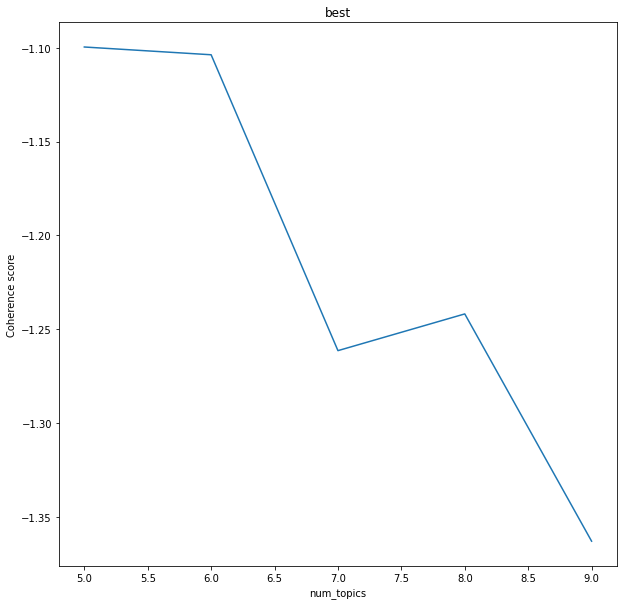

In [127]:
print_coherence(lda_models, 0, "LDA", "best")

Среднее (с учётом использования/tuning-а других параметров)

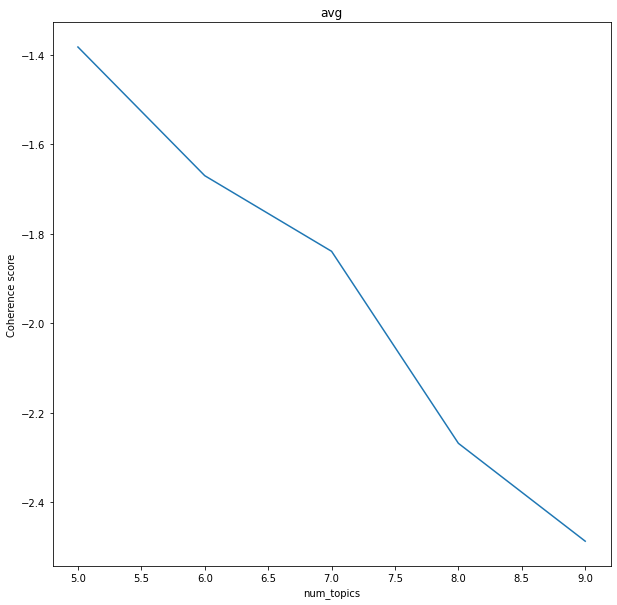

In [128]:
print_coherence(lda_models, 0, "LDA", "avg")

### Вывод зависимости когеренции от параметра альфа

Лучшее (не обращаем внимание на tuning других параметров, взята лучшая комбинация при фиксированном параметре)

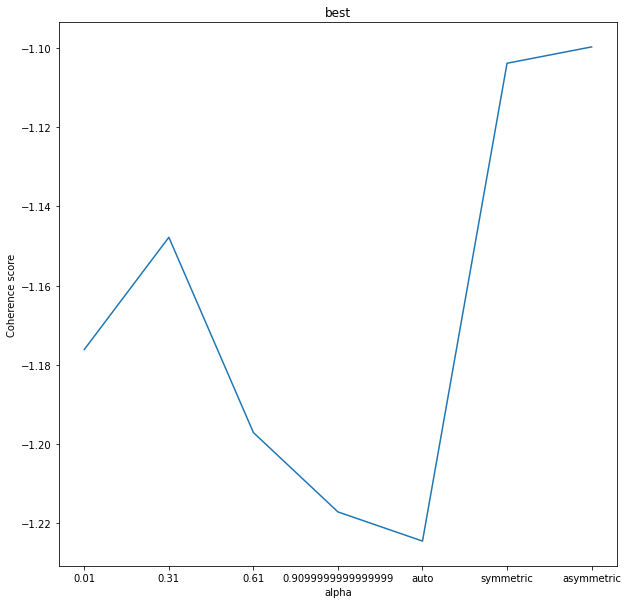

In [129]:
print_coherence(lda_models, 1, "LDA", "best")

Среднее (с учётом использования/tuning-а других параметров)

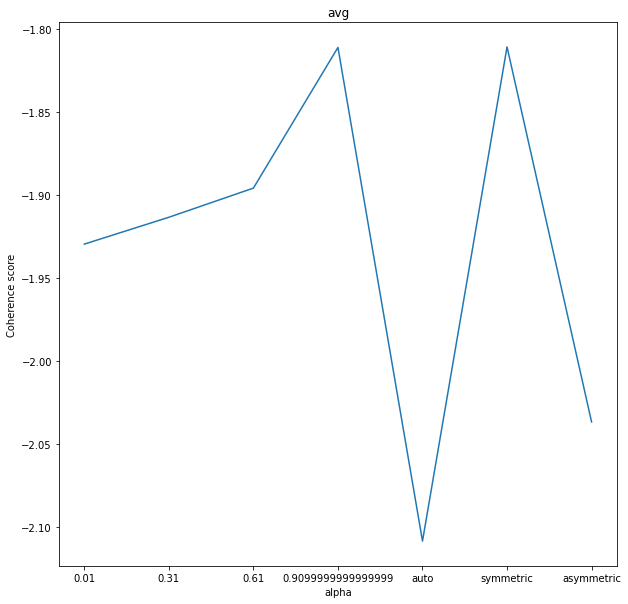

In [130]:
print_coherence(lda_models, 1, "LDA", "avg")

### Вывод зависимости когеренции от параметра бета

Лучшее (не обращаем внимание на tuning других параметров, взята лучшая комбинация при фиксированном параметре)

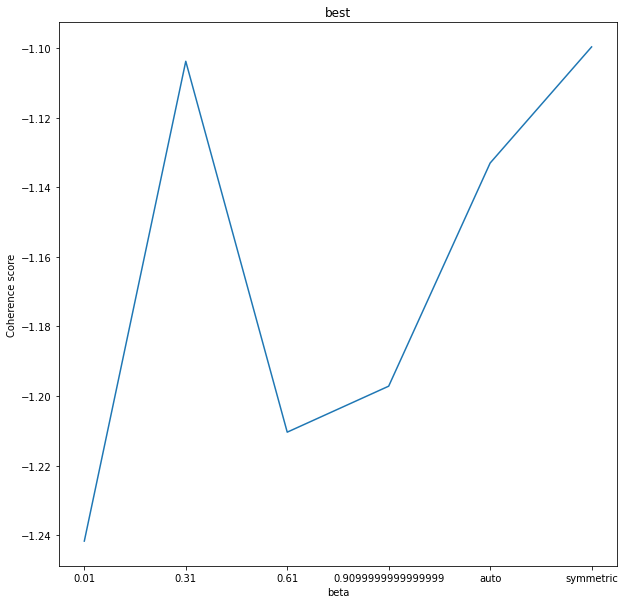

In [131]:
print_coherence(lda_models, 2, "LDA", "best")

Среднее (с учётом использования/tuning-а других параметров)

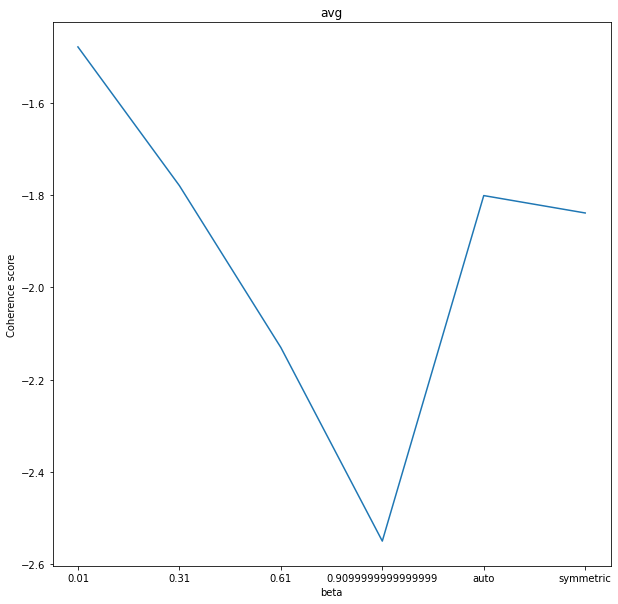

In [132]:
print_coherence(lda_models, 2, "LDA", "avg")

In [54]:
lda_models_sorted = sorted(lda_models, key=lambda d: d['coherence'])

Вывод лучшей LDA модели

In [57]:
lda_models_sorted[-1]["model"].show_topics()

[(0,
  '0.015*"человек" + 0.011*"год" + 0.006*"ребёнок" + 0.006*"время" + 0.005*"врач" + 0.005*"день" + 0.004*"россия" + 0.004*"раз" + 0.003*"случай" + 0.003*"работа"'),
 (1,
  '0.018*"команда" + 0.017*"игра" + 0.016*"матч" + 0.013*"нижний_новгород" + 0.008*"болельщик" + 0.008*"нижегородец" + 0.007*"счёт" + 0.006*"торпедо" + 0.006*"соперник" + 0.006*"игрок"'),
 (2,
  '0.014*"год" + 0.007*"архангельск" + 0.006*"город" + 0.005*"проект" + 0.005*"фестиваль" + 0.004*"фильм" + 0.004*"новый" + 0.004*"время" + 0.004*"день" + 0.004*"работа"'),
 (3,
  '0.015*"автомобиль" + 0.011*"машина" + 0.010*"год" + 0.008*"рубль" + 0.007*"водитель" + 0.006*"новый" + 0.005*"цена" + 0.005*"россия" + 0.004*"модель" + 0.003*"дорога"'),
 (4,
  '0.025*"год" + 0.017*"рубль" + 0.008*"банк" + 0.006*"россия" + 0.004*"компания" + 0.004*"регион" + 0.004*"деньга" + 0.004*"цена" + 0.004*"страна" + 0.004*"новый"')]

Вывод худшей LDA модели

In [56]:
lda_models_sorted[0]["model"].show_topics()

[(0,
  '0.018*"год" + 0.014*"человек" + 0.009*"ребёнок" + 0.008*"жизнь" + 0.007*"время" + 0.005*"работа" + 0.005*"фильм" + 0.004*"хороший" + 0.004*"пациент" + 0.004*"новый"'),
 (1,
  '0.013*"автомобиль" + 0.011*"машина" + 0.008*"кроссовер" + 0.008*"двигатель" + 0.007*"модель" + 0.006*"квитанция" + 0.006*"версия" + 0.006*"новый" + 0.005*"мотор" + 0.005*"салон"'),
 (2,
  '0.009*"рубль_килограмм" + 0.007*"экономический_форум" + 0.006*"шина" + 0.003*"резина" + 0.003*"право_собственность" + 0.002*"шиномонтаж" + 0.001*"зимний_резина" + 0.001*"экономика_регион" + 0.001*"coca_cola" + 0.001*"бурлак"'),
 (3,
  '0.030*"год" + 0.017*"рубль" + 0.010*"банк" + 0.005*"регион" + 0.005*"работа" + 0.005*"деньга" + 0.004*"вклад" + 0.004*"россия" + 0.004*"средство" + 0.004*"компания"'),
 (4,
  '0.017*"человек" + 0.012*"врач" + 0.009*"случай" + 0.006*"коронавирус" + 0.006*"водитель" + 0.006*"день" + 0.005*"препарат" + 0.004*"заболевание" + 0.004*"ребёнок" + 0.004*"ситуация"'),
 (5,
  '0.018*"монета" + 0.008

In [ ]:
pyLDAvis.enable_notebook()
visualisation = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
print(visualisation)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.074619  0.154864       1        1  22.020071
2     -0.162872 -0.048315       2        1  15.871222
4     -0.102134  0.094010       3        1  15.208968
0     -0.187363  0.035419       4        1  14.519415
1     -0.086907  0.033993       5        1   6.953353
5     -0.012822 -0.074227       6        1   6.931545
3      0.212048  0.138440       7        1   5.909345
9      0.060628 -0.193241       8        1   5.774899
8      0.258781  0.108322       9        1   3.974532
7      0.095260 -0.249265      10        1   2.836651, topic_info=                 Term         Freq        Total Category  logprob  loglift
183             рубль  5817.000000  5817.000000  Default  30.0000  30.0000
1341  нижний_новгород  2301.000000  2301.000000  Default  29.0000  29.0000
232              цена  2473.000000  2473.000000  Default  28.0000  28.0000
2230       автомобиль  3156.000000  3156.000000  Default  27.0000  27.0000
482           человек  9382.000000  9382.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
1726           клиент   142.588349   931.006947  Topic10  -5.5741   1.6862
7116    производитель   114.941968   433.319056  Topic10  -5.7896   2.2355
1402   дополнительный   120.180578   708.418716  Topic10  -5.7451   1.7885
261               вид   126.668108  1227.977542  Topic10  -5.6925   1.2910
4149          дорогой   111.620593   499.630215  Topic10  -5.8189   2.0638

[721 rows x 6 columns], token_table=       Topic      Freq              Term
term                                    
4074       7  0.026395             apple
4074      10  0.950210             apple
34982      8  0.980822            arkana
51717     10  0.977952              back
33662      8  0.982068             camry
...      ...       ...               ...
7318       1  0.995471              юный
241        2  0.989494  юридический_лицо
2229       3  0.023316             юрист
2229       4  0.886020             юрист
2229       6  0.089379             юрист

[1702 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 5, 1, 2, 6, 4, 10, 9, 8])

In [ ]:
# with open(LDAvis_data_filepath, 'wb') as f:
#     pickle.dump(LDAvis_prepared, f)

pyLDAvis.save_html(visualisation, '/content/drive/MyDrive/Универ/results/lda_best_visual.html')

### Тематическая согласованность (Topic Coherence)
Чем выше значение когерентности, тем лучше модель

In [ ]:
def evaluate_bar_graph(coherences, indices): # функция для вывода bar графика
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices) # проверка на равное число элементов
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

In [ ]:
# ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
# lda_coherence = CoherenceModel(topics=ldatopics, texts=texts_v2, dictionary=dictionary, window_size=10).get_coherence() # рассчитывает согласованность тем для topic models

In [ ]:
# evaluate_bar_graph([lda_coherence],
#                    ['LDA'])

In [ ]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

# hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

nmftopics = [[word for word, prob in topic] for topicid, topic in nmfmodel.show_topics(formatted=False)]

In [ ]:
# подсчёт когерентности моделей
lsi_coherence = CoherenceModel(topics=lsitopics, texts=texts_v2, dictionary=dictionary, window_size=10).get_coherence()

# hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts_v2, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts_v2, dictionary=dictionary, window_size=10).get_coherence()

nmf_coherence = CoherenceModel(topics=nmftopics, texts=texts_v2, dictionary=dictionary, window_size=10).get_coherence()

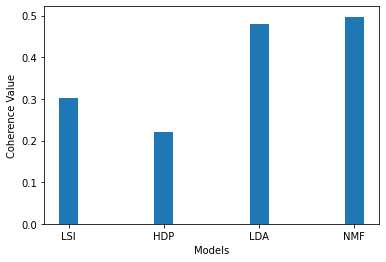

In [ ]:
evaluate_bar_graph([lsi_coherence, lda_coherence, nmf_coherence],
                   ['LSI', 'LDA', 'NMF'])

word2vec сравнить созданные лучшей моделью топики (померить косинусную меру)